# MODELOS PREDICTIVOS

En este caso se usará el dataset de Spotify con los datos ya preparados y limpios después de haber pasado por la revisión de calidad de datos.

Para las predicciones se usarán los modelos de Árbol de Decisiones, KNN, Red Neuronal, SVM y Random Forest. Para calificar la calidad de los modelos se usará una validación cruzada.

In [1]:
# Imports
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

Matplotlib is building the font cache; this may take a moment.


## PREPARACIÓN DE LOS DATOS

In [2]:
# Cargamos los datos desde el csv
data = pd.read_csv("spotify_cleaned.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   danceability    195 non-null    float64
 1   loudness        195 non-null    float64
 2   speechiness     195 non-null    float64
 3   valence         195 non-null    float64
 4   tempo           195 non-null    float64
 5   time_signature  195 non-null    int64  
 6   liked           195 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 10.8 KB


In [3]:
# Corrección de tipos de datos
data['time_signature']=data['time_signature'].astype('category')
data['liked']=data['liked'].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   danceability    195 non-null    float64 
 1   loudness        195 non-null    float64 
 2   speechiness     195 non-null    float64 
 3   valence         195 non-null    float64 
 4   tempo           195 non-null    float64 
 5   time_signature  195 non-null    category
 6   liked           195 non-null    category
dtypes: category(2), float64(5)
memory usage: 8.4 KB


<Axes: xlabel='liked'>

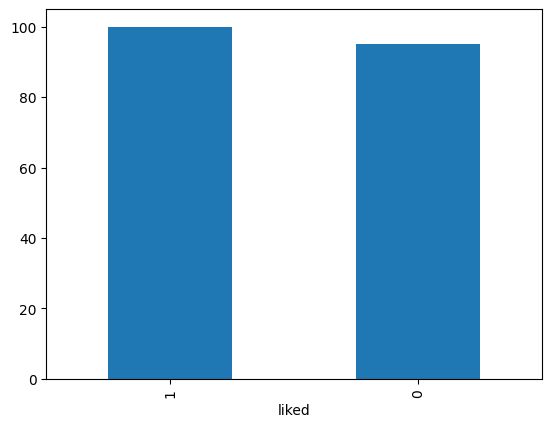

In [4]:
# Distribución de la variable objetivo
data['liked'].value_counts().plot(kind='bar')

In [5]:
# Se crean dummies en las variables categóricas
data_numeric = pd.get_dummies(data, columns=['time_signature'], drop_first=False, dtype=int)
data_numeric.head()

,danceability,loudness,speechiness,valence,tempo,liked,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,0.856,-8.173,0.3360,0.723,142.950,1,0,0,1,0
1,0.789,-5.290,0.0970,0.494,136.059,1,0,0,1,0
2,0.816,-8.561,0.0758,0.402,134.985,1,0,1,0,0
3,0.915,-10.490,0.3430,0.753,124.906,1,0,0,1,0
4,0.798,-6.610,0.4160,0.659,73.679,1,0,0,1,0


In [6]:
# LabelEncoder para la variable objetivo
labelencoder = LabelEncoder()
data_numeric['liked'] = labelencoder.fit_transform(data_numeric['liked'])

data_numeric

,danceability,loudness,speechiness,valence,tempo,liked,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,0.856,-8.173,0.3360,0.723,142.950,1,0,0,1,0
1,0.789,-5.290,0.0970,0.494,136.059,1,0,0,1,0
2,0.816,-8.561,0.0758,0.402,134.985,1,0,1,0,0
3,0.915,-10.490,0.3430,0.753,124.906,1,0,0,1,0
4,0.798,-6.610,0.4160,0.659,73.679,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
190,0.251,-7.282,0.1180,0.275,99.338,0,0,0,1,0
191,0.267,-42.261,0.0531,0.267,71.428,0,0,0,1,0
192,0.780,-13.038,0.0625,0.969,126.009,0,0,0,1,0
193,0.263,-17.687,0.0408,0.120,71.462,0,0,0,1,0


## ENTRENAMIENTO Y EVALUCIÓN

### Configuración de validación cruzada

In [7]:
# Validación Cruzada
# Dataframe para comparar los modelos
comparacion_CV = pd.DataFrame()
scoring = ('f1', 'accuracy','precision', 'recall')
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # Muestreo estratificado

In [8]:
# Se separa variables predictoras y objetivo
X = data.drop("liked", axis = 1)
Y = data['liked']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   danceability    195 non-null    float64 
 1   loudness        195 non-null    float64 
 2   speechiness     195 non-null    float64 
 3   valence         195 non-null    float64 
 4   tempo           195 non-null    float64 
 5   time_signature  195 non-null    category
dtypes: category(1), float64(5)
memory usage: 8.1 KB


In [9]:
# Se separa variables predictoras y objetivo para el dataset con dummies
X_num = data_numeric.drop("liked", axis = 1)
Y_num = data_numeric['liked']
X_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      195 non-null    float64
 1   loudness          195 non-null    float64
 2   speechiness       195 non-null    float64
 3   valence           195 non-null    float64
 4   tempo             195 non-null    float64
 5   time_signature_1  195 non-null    int64  
 6   time_signature_3  195 non-null    int64  
 7   time_signature_4  195 non-null    int64  
 8   time_signature_5  195 non-null    int64  
dtypes: float64(5), int64(4)
memory usage: 13.8 KB


### Árbol de Decisiones

In [20]:
# Configuración de parámetros
modelTree = tree.DecisionTreeClassifier(criterion='gini', min_samples_leaf=200, max_depth=None)
# Validación cruzada
scores_tree = cross_validate(modelTree, X, Y, cv=cv, scoring=scoring, return_train_score=True, return_estimator=False)
scores_tree = pd.DataFrame(scores_tree) # Se almacenan los resultados en un dataframe
# Se imprimen los resultados
scores_tree

,fit_time,score_time,test_f1,train_f1,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall
0,0.010020,0.004588,0.666667,0.679245,0.500000,0.514286,0.500000,0.514286,1.0,1.0
1,0.000750,0.002853,0.666667,0.679245,0.500000,0.514286,0.500000,0.514286,1.0,1.0
2,0.000834,0.003003,0.666667,0.679245,0.500000,0.514286,0.500000,0.514286,1.0,1.0
3,0.000957,0.002878,0.666667,0.679245,0.500000,0.514286,0.500000,0.514286,1.0,1.0
4,0.000727,0.002668,0.666667,0.679245,0.500000,0.514286,0.500000,0.514286,1.0,1.0
5,0.000958,0.003176,0.689655,0.676692,0.526316,0.511364,0.526316,0.511364,1.0,1.0
6,0.000825,0.002741,0.689655,0.676692,0.526316,0.511364,0.526316,0.511364,1.0,1.0
7,0.000670,0.002596,0.689655,0.676692,0.526316,0.511364,0.526316,0.511364,1.0,1.0
8,0.000653,0.002584,0.689655,0.676692,0.526316,0.511364,0.526316,0.511364,1.0,1.0
9,0.000640,0.002659,0.689655,0.676692,0.526316,0.511364,0.526316,0.511364,1.0,1.0


In [21]:
# Modelo final Árbol
modelTree.fit(X, Y) # 100% de los datos

DecisionTreeClassifier(min_samples_leaf=200)

### KNN

In [12]:
# Normalizacion de las variables numéricas (Sin Dummies)
min_max_scaler = MinMaxScaler()
var_num=['loudness','tempo']
min_max_scaler.fit(X_num[var_num]) # Ajuste de los parametros: max - min
X_num[var_num]= min_max_scaler.transform(X_num[var_num])
X_num.head()

,danceability,loudness,speechiness,valence,tempo,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,0.856,0.853801,0.3360,0.723,0.690602,0,0,1,0
1,0.789,0.926011,0.0970,0.494,0.633112,0,0,1,0
2,0.816,0.844083,0.0758,0.402,0.624152,0,1,0,0
3,0.915,0.795767,0.3430,0.753,0.540066,0,0,1,0
4,0.798,0.892949,0.4160,0.659,0.112693,0,0,1,0


In [22]:
# Configuración de parámetros
# Método Perezoso
modelKNN = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
# Validación cruzada
scores_knn = cross_validate(modelKNN, X_num, Y_num, cv=cv, scoring=scoring, return_train_score=True, return_estimator=False)
scores_knn = pd.DataFrame(scores_knn) # Se almacenan los resultados en un dataframe
# Se imprimen los resultados
scores_knn

,fit_time,score_time,test_f1,train_f1,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall
0,0.008348,0.054057,0.761905,1.0,0.750000,1.0,0.727273,1.0,0.8,1.0
1,0.003756,0.005286,0.842105,1.0,0.850000,1.0,0.888889,1.0,0.8,1.0
2,0.000742,0.003260,0.736842,1.0,0.750000,1.0,0.777778,1.0,0.7,1.0
3,0.000706,0.002982,0.800000,1.0,0.800000,1.0,0.800000,1.0,0.8,1.0
4,0.000631,0.003211,0.900000,1.0,0.900000,1.0,0.900000,1.0,0.9,1.0
5,0.000730,0.003181,0.842105,1.0,0.842105,1.0,0.888889,1.0,0.8,1.0
6,0.000769,0.003278,0.947368,1.0,0.947368,1.0,1.000000,1.0,0.9,1.0
7,0.000751,0.003069,0.777778,1.0,0.789474,1.0,0.875000,1.0,0.7,1.0
8,0.000724,0.003742,0.818182,1.0,0.789474,1.0,0.750000,1.0,0.9,1.0
9,0.000722,0.003395,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.0,1.0


In [23]:
# Modelo final KNN
modelKNN.fit(X_num, Y_num) # 100% de los datos

KNeighborsClassifier(metric='euclidean', n_neighbors=1)

### Red Neuronal

In [24]:
# Configuración de parámetros
# Solo se configura capas ocultas, no se configura capa de entrada y de salida
modelNN = MLPClassifier(activation="logistic",hidden_layer_sizes=(5), learning_rate='constant',
                     learning_rate_init=0.2, momentum= 0.3, max_iter=500, random_state=3)
# Validación cruzada
scores_nn = cross_validate(modelNN, X_num, Y_num, cv=cv, scoring=scoring, return_train_score=True, return_estimator=False)
scores_nn = pd.DataFrame(scores_nn)
# Se imprimen los resultados
scores_nn

/Users/sebastianmarin/Documents/UPB/Analítica/spotify-predict/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sebastianmarin/Documents/UPB/Analítica/spotify-predict/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sebastianmarin/Documents/UPB/Analítica/spotify-predict/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sebastianmarin/Documents/UPB/Analítica/spotify-predict/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron

,fit_time,score_time,test_f1,train_f1,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall
0,0.076930,0.005176,0.800000,0.994475,0.800000,0.994286,0.800000,0.989011,0.8,1.000000
1,0.057122,0.003470,0.857143,0.994475,0.850000,0.994286,0.818182,0.989011,0.9,1.000000
2,0.059131,0.002981,0.842105,0.989011,0.850000,0.988571,0.888889,0.978261,0.8,1.000000
3,0.058103,0.002972,0.888889,0.989011,0.900000,0.988571,1.000000,0.978261,0.8,1.000000
4,0.051062,0.002900,0.833333,0.988889,0.800000,0.988571,0.714286,0.988889,1.0,0.988889
5,0.040307,0.002666,0.761905,0.972067,0.736842,0.971591,0.727273,0.977528,0.8,0.966667
6,0.044263,0.002763,0.842105,0.983425,0.842105,0.982955,0.888889,0.978022,0.8,0.988889
7,0.049594,0.002699,0.800000,0.994475,0.789474,0.994318,0.800000,0.989011,0.8,1.000000
8,0.044794,0.002874,0.909091,0.994475,0.894737,0.994318,0.833333,0.989011,1.0,1.000000
9,0.023776,0.002486,1.000000,0.905028,1.000000,0.903409,1.000000,0.910112,1.0,0.900000


In [25]:
# Modelo final Red Neuronal
modelNN.fit(X_num, Y_num) # 100% de los datos

/Users/sebastianmarin/Documents/UPB/Analítica/spotify-predict/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', hidden_layer_sizes=5,
              learning_rate_init=0.2, max_iter=500, momentum=0.3,
              random_state=3)

### SVM

In [26]:
# Configuración de parámetros
modelSVM = SVC(kernel='linear') #'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
# Validación cruzada
scores_svm = cross_validate(modelSVM, X_num, Y_num, cv=cv, scoring=scoring, return_train_score=True, return_estimator=False)
scores_svm = pd.DataFrame(scores_svm)
# Se imprimen los resultados
scores_svm

,fit_time,score_time,test_f1,train_f1,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall
0,0.012898,0.008013,0.800000,0.850829,0.800000,0.845714,0.800000,0.846154,0.8,0.855556
1,0.002009,0.004160,0.823529,0.850575,0.850000,0.851429,1.000000,0.880952,0.7,0.822222
2,0.001380,0.003771,0.800000,0.839779,0.800000,0.834286,0.800000,0.835165,0.8,0.844444
3,0.001228,0.002963,0.800000,0.870968,0.800000,0.862857,0.800000,0.843750,0.8,0.900000
4,0.001054,0.002880,0.782609,0.860335,0.750000,0.857143,0.692308,0.865169,0.9,0.855556
5,0.001054,0.002759,0.818182,0.845714,0.789474,0.846591,0.750000,0.870588,0.9,0.822222
6,0.000936,0.002542,0.736842,0.852459,0.736842,0.846591,0.777778,0.838710,0.7,0.866667
7,0.000938,0.002532,0.842105,0.852459,0.842105,0.846591,0.888889,0.838710,0.8,0.866667
8,0.000899,0.002473,0.750000,0.866667,0.684211,0.863636,0.642857,0.866667,0.9,0.866667
9,0.000935,0.002463,1.000000,0.824176,1.000000,0.818182,1.000000,0.815217,1.0,0.833333


In [27]:
# Modelo final SVM
modelSVM.fit(X_num, Y_num) # 100% de los datos

SVC(kernel='linear')

### Random Forest

In [28]:
# Configuración de parámetros
modelRF= RandomForestClassifier(n_estimators=100,  max_samples=0.7, criterion='gini',
                              max_depth=None, min_samples_leaf=2)
# Validación cruzada
scores_rf = cross_validate(modelRF, X, Y, cv=cv, scoring=scoring, return_train_score=True, return_estimator=False)
scores_rf = pd.DataFrame(scores_rf)
# Se imprimen los resultados
scores_rf

,fit_time,score_time,test_f1,train_f1,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall
0,0.078524,0.005844,0.952381,0.978022,0.950000,0.977143,0.909091,0.967391,1.0,0.988889
1,0.050465,0.005275,0.842105,0.972376,0.850000,0.971429,0.888889,0.967033,0.8,0.977778
2,0.053715,0.006173,0.900000,0.988889,0.900000,0.988571,0.900000,0.988889,0.9,0.988889
3,0.054816,0.005586,0.888889,0.978022,0.900000,0.977143,1.000000,0.967391,0.8,0.988889
4,0.057313,0.006829,0.818182,0.978022,0.800000,0.977143,0.750000,0.967391,0.9,0.988889
5,0.055098,0.006941,0.736842,0.977778,0.736842,0.977273,0.777778,0.977778,0.7,0.977778
6,0.047897,0.004920,0.736842,0.988889,0.736842,0.988636,0.777778,0.988889,0.7,0.988889
7,0.047163,0.005732,0.947368,0.983425,0.947368,0.982955,1.000000,0.978022,0.9,0.988889
8,0.048206,0.004930,0.909091,0.977778,0.894737,0.977273,0.833333,0.977778,1.0,0.977778
9,0.054708,0.005057,1.000000,0.972376,1.000000,0.971591,1.000000,0.967033,1.0,0.977778


In [31]:
# Modelo final Random Forest
modelRF.fit(X, Y) # 100% de los datos

RandomForestClassifier(max_samples=0.7, min_samples_leaf=2)

## COMPARACIÓN
A continuación se hará la comparación de los resultados obtenidos de todos los modelos para definir cuál fue el mejor, esta comparación se hará sacando los promedios de Precisión, Recall y F1, y luego llevándolos a una tabla para facilitar la lectura.

In [30]:
# Se crea un diccionario para almacenar los resultados promedio de cada modelo
resultados = {
    'Modelo': ['Árbol de Decisiones', 'KNN', 'Red Neuronal', 'SVM', 'Random Forest'],
    'Recall Promedio': [],
    'Precisión Promedio': [],
    'F1 Promedio': []
}

# Lista de los DataFrames de resultados de cada modelo
scores_list = [
    scores_tree,
    scores_knn,
    scores_nn,
    scores_svm,
    scores_rf
]

# Calcular los promedios y agregarlos al diccionario
for scores in scores_list:
    resultados['Recall Promedio'].append(scores['test_recall'].mean())
    resultados['Precisión Promedio'].append(scores['test_precision'].mean())
    resultados['F1 Promedio'].append(scores['test_f1'].mean())

# Crear un DataFrame para mostrar los resultados
tabla_comparacion = pd.DataFrame(resultados)

# Mostrar la tabla
print(tabla_comparacion)

                Modelo  Recall Promedio  Precisión Promedio  F1 Promedio
0  Árbol de Decisiones             1.00            0.513158     0.678161
1                  KNN             0.83            0.860783     0.842629
2         Red Neuronal             0.87            0.847085     0.853457
3                  SVM             0.83            0.815183     0.815327
4        Random Forest             0.87            0.883687     0.873170


Como se puede ver, los resultados de KNN, NN, SVM y Random Forest son bastante similares, mientras que los del Árbol son un poco confusos y no tan buenos. En este caso las mejores métricas son las del Random Forest por lo cual, es el que se usará para el despliegue.

## SE GUARDA EL MODELO PARA DESPLIEGUE
Se guarda el modelo de Random Forest en un archivo de Pickle para ser usado en el Notebook de despliegue.

In [32]:
filename = 'RandomForest.pkl'
variables= X.columns._values
pickle.dump([modelRF, labelencoder, variables], open(filename, 'wb'))